In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import requests
import json
import time

from understatapi import UnderstatClient
plt.style.use('ggplot')


In [2]:
understat = UnderstatClient()


In [4]:
# Get shot data for all matches for a given season
# define dataframe for shots

def getShotsForLeague(league, seasons):
  shots_df = pd.DataFrame()
  league_data = understat.league(league=league)
  for season in seasons:
    league_matches = league_data.get_match_data(season=season)
    for match in league_matches:
      match_id = match['id']
      try:
        match_shots = understat.match(match_id).get_shot_data()
        for k in ['h', 'a']:
          # add shots to shots_df concat
          shots_df = pd.concat([shots_df, pd.DataFrame(match_shots[k])])  
      except:
        pass  
  return shots_df

leagues = ["EPL", "La_Liga", "Serie_A", "Bundesliga", "Ligue_1"]
seasons = ["2017","2018", "2019", "2020", "2021" "2022"]

shots_df_epl = getShotsForLeague('EPL', seasons)
shots_df_bundesliga = getShotsForLeague('Bundesliga', seasons)
shots_df_laliga = getShotsForLeague('La_Liga', seasons)
shots_df_seriea = getShotsForLeague('Serie_A', seasons)
shots_df_ligue1 = getShotsForLeague('Ligue_1', seasons)

In [5]:
shots_df_epl['league'] = 'EPL'
shots_df_bundesliga['league'] = 'Bundesliga'
shots_df_laliga['league'] = 'La Liga'
shots_df_seriea['league'] = 'Serie A'
shots_df_ligue1['league'] = 'Ligue 1'

shots_df = pd.concat([shots_df_epl, shots_df_bundesliga, shots_df_laliga, shots_df_seriea, shots_df_ligue1])

In [6]:
len(shots_df[shots_df["result"]=="Goal"])

21292

In [7]:
# save shots_df to csv
shots_df.to_csv('shots_df.csv', index=False)

In [ ]:
shots_df = pd.read_csv('shots_df.csv')

In [8]:
shots_df[shots_df['h_a'] == 'a'].tail()

# set X, Y as float
shots_df['X'] = shots_df['X'].astype(float)
shots_df['Y'] = shots_df['Y'].astype(float)

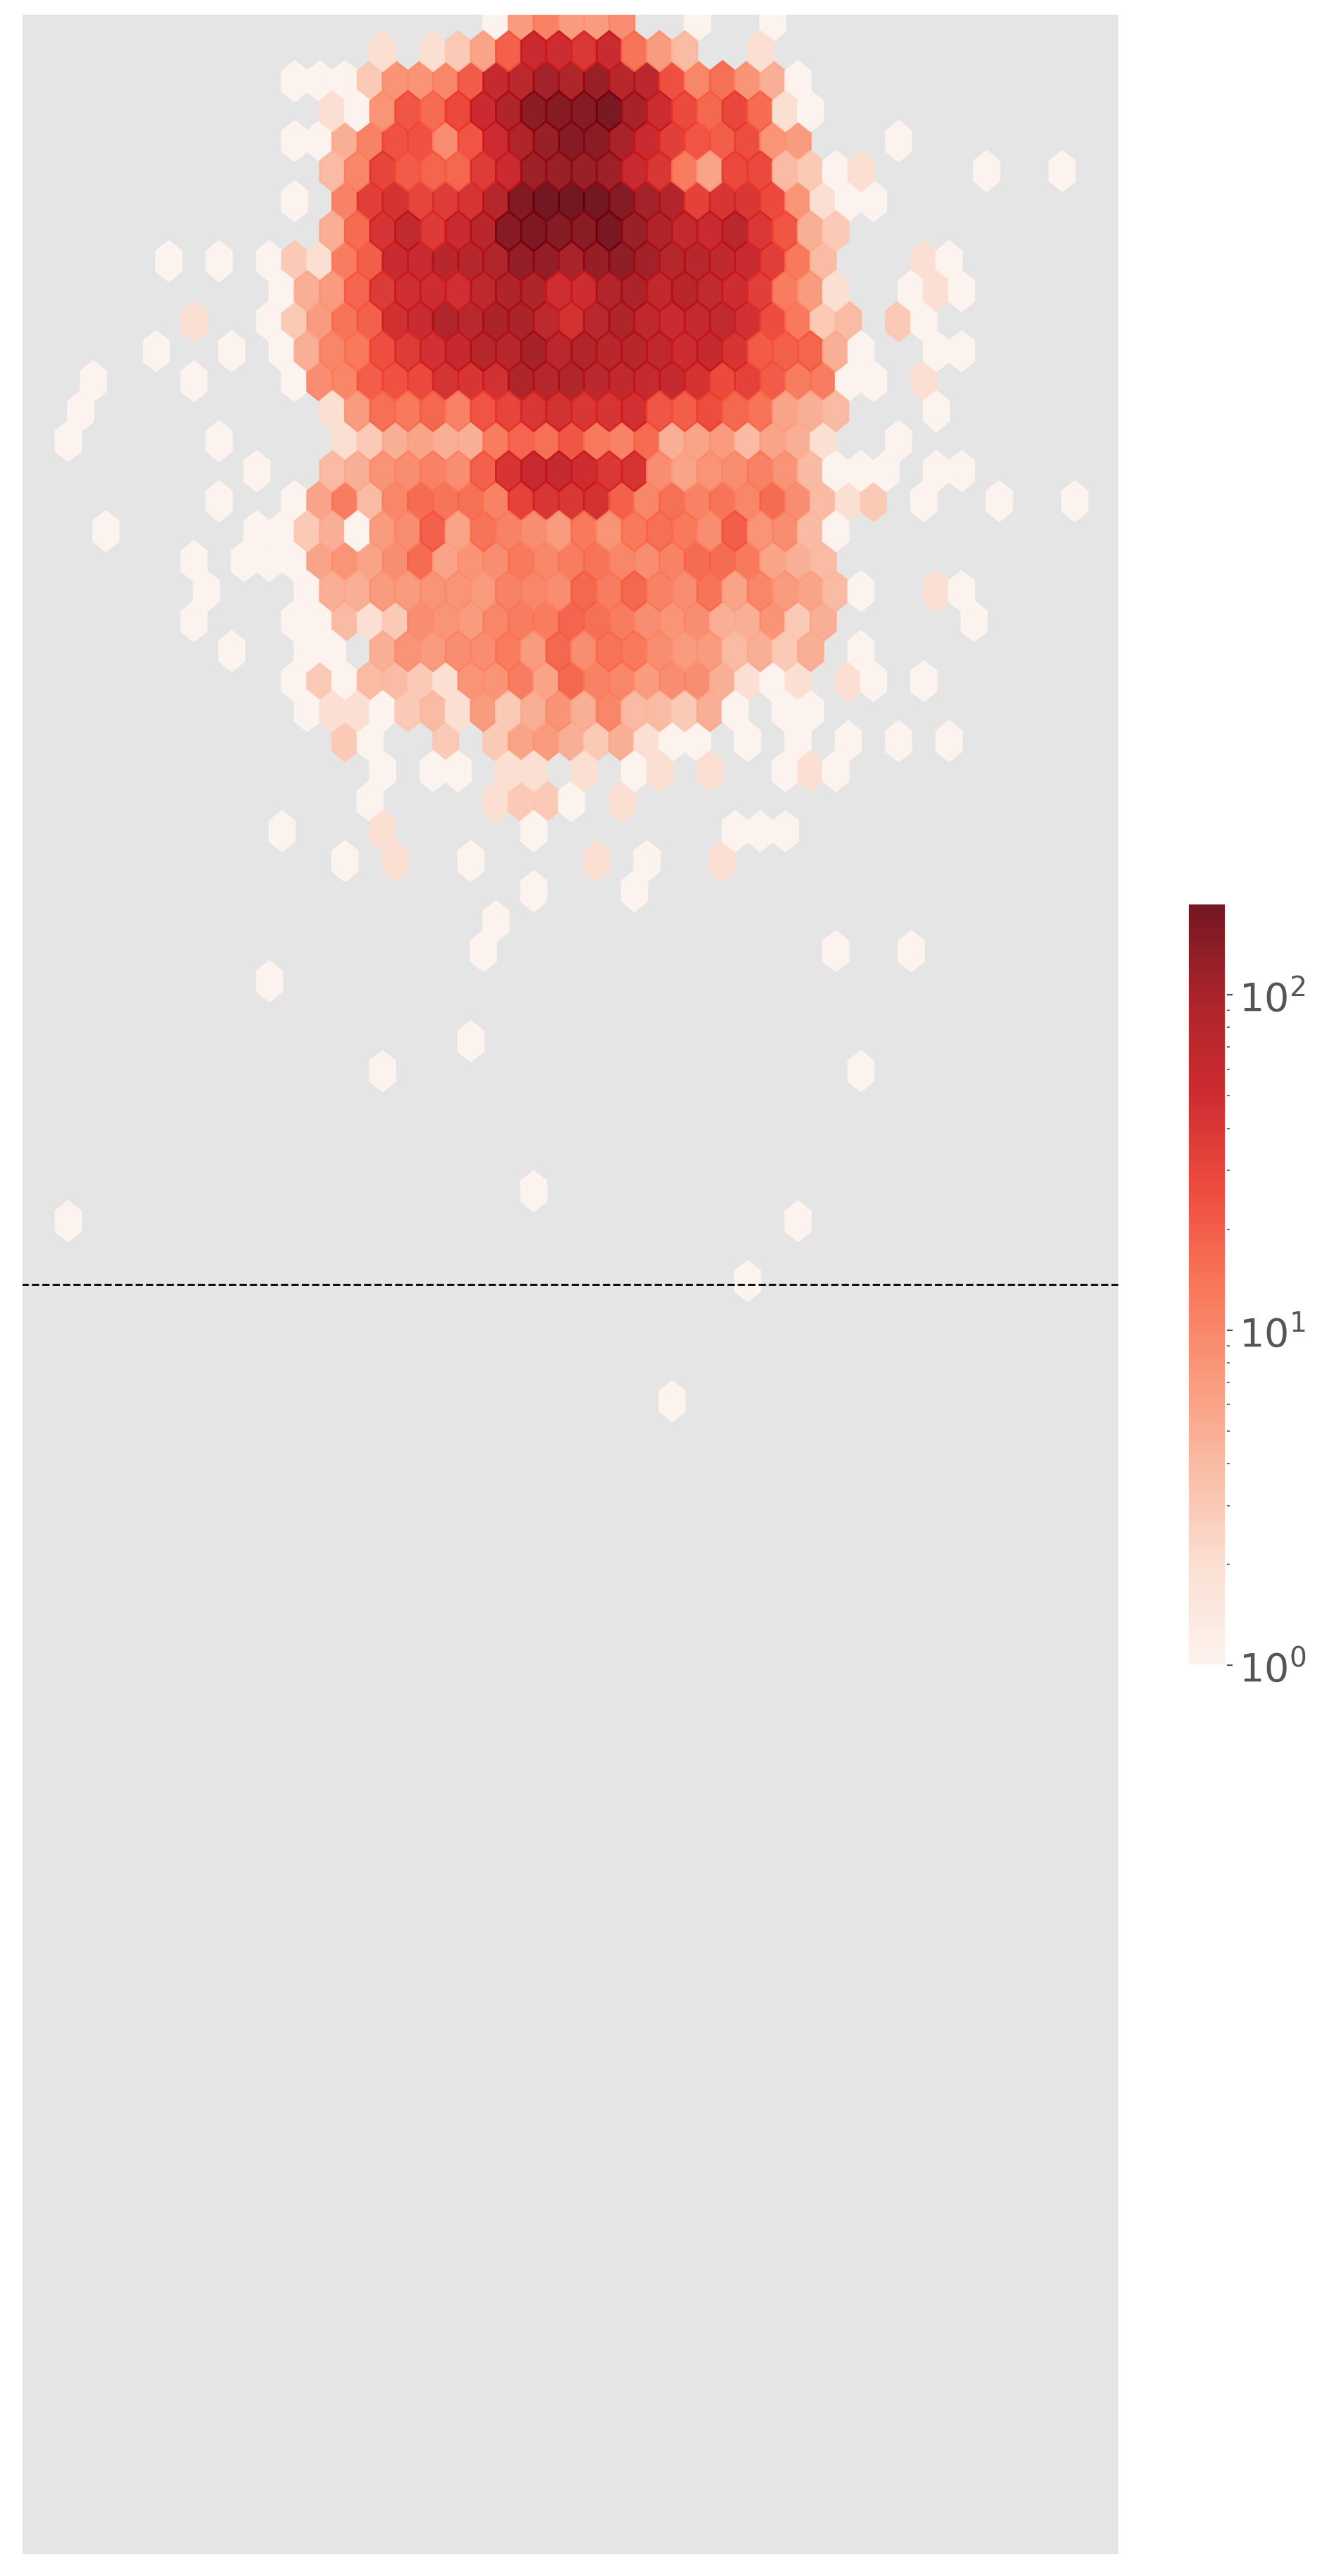

In [9]:

shots = shots_df[shots_df['result'] == 'Goal']
shots = shots[shots['situation'] == 'OpenPlay']
# shots = shots[~shots['situation'].isin(['Penalty', 'Penalty shootout'])]
x = shots['X']
y = shots['Y']

# plot X,Y hexbin
A = 2
plt.rc('figure', figsize=[25.11 * .5**(.5 * A), 46.82 * .5**(.5 * A)], dpi=200)
plt.hexbin(y, x, gridsize=40, cmap=plt.cm.Reds, bins='log', alpha=0.9)
plt.xlim(0, 1)
plt.ylim(0, 1)

# add colorbar below 
cbar = plt.colorbar(location='right', pad=0.05, shrink=0.3)
cbar.ax.tick_params(labelsize=20)
#disable axes
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

# add bar in the middle y
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)
# save with transparent background
plt.savefig('hexbin.png', transparent=True)
plt.show()

In [10]:
# get average shots per game

def getAverageShotsPerGame(shots_df):
  # get total shots
  total_shots = len(shots_df)
  # get total games
  total_games = len(shots_df['match_id'].unique())
  # get average shots per game
  avg_shots_per_game = total_shots / total_games
  return avg_shots_per_game

getAverageShotsPerGame(shots_df)

25.007067137809187

In [11]:
# average goal per game

def getAverageGoalsPerGame(shots_df):
  # get total goals
  total_goals = len(shots_df[shots_df['result'] == 'Goal'])
  # get total games
  total_games = len(shots_df['match_id'].unique())
  # get average shots per game
  avg_goals_per_game = total_goals / total_games
  return avg_goals_per_game

getAverageGoalsPerGame(shots_df)

2.687026754164563

In [12]:
# free kick goals probability

def getFreeKickGoalsProbability(shots_df):
  # get total free kicks
  total_free_kicks = len(shots_df[shots_df['situation'] == 'DirectFreekick'])
  # get total goals
  total_goals = len(shots_df[(shots_df['result'] == 'Goal') & (shots_df['situation'] == 'DirectFreekick')])
  # get free kick goals probability
  free_kick_goals_probability = total_goals / total_free_kicks
  return free_kick_goals_probability

getFreeKickGoalsProbability(shots_df)


0.059518013631937684

In [13]:
# Set piece goals probability

def getSetPieceGoalsProbability(shots_df):
  # get total set pieces
  total_set_pieces = len(shots_df[shots_df['situation'].isin(['DirectFreekick', 'Penalty', 'SetPiece', 'Corner'])])
  # get total goals
  total_goals = len(shots_df[(shots_df['result'] == 'Goal') & (shots_df['situation'].isin(['DirectFreekick', 'Penalty', 'SetPiece', 'Corner']))])
  # get free kick goals probability
  set_piece_goals_probability = total_goals / total_set_pieces
  return set_piece_goals_probability

getSetPieceGoalsProbability(shots_df)


0.15789473684210525

In [15]:
# get unique match_ids for each league

shots_df_all = shots_df

In [16]:
daten = pd.DataFrame(shots_df_all.groupby(['league', 'h_a']).count()['id'] / shots_df_all.groupby(['league', 'h_a']).nunique()['match_id'])

In [17]:
daten

0
league     h_a           
Bundesliga a    11.840324
           h    14.089838
EPL        a    11.265465
           h    13.542342
La Liga    a    10.339964
           h    12.927711
Ligue 1    a    11.132653
           h    13.321224
Serie A    a    12.260635
           h    14.486228

In [18]:
daten.reset_index(inplace=True)
daten.columns = ['league', 'h_a', 'shots_per_match']

In [19]:
daten = daten.pivot(index='league', columns='h_a', values='shots_per_match')

In [20]:
pd.DataFrame(daten['a']).reset_index()['a']

0    11.840324
1    11.265465
2    10.339964
3    11.132653
4    12.260635
Name: a, dtype: float64

In [21]:
daten = pd.DataFrame(shots_df_all.groupby(['league', 'h_a']).count()['id'] / shots_df_all.groupby(['league', 'h_a']).nunique()['match_id'])
daten.reset_index(inplace=True)

In [22]:
home = daten[daten['h_a'] == 'h']
away = daten[daten['h_a'] == 'a']


# merge home and away dataframes

home_away = pd.merge(home, away, on='league')

In [23]:
home_away.drop(columns=['h_a_x', 'h_a_y'], inplace=True)

In [24]:
home_away.columns = ['league', 'home_shots_per_match', 'away_shots_per_match']
home_away

ordered_df = home_away.sort_values(by=['away_shots_per_match'])
my_range=range(1,len(ordered_df.index)+1)

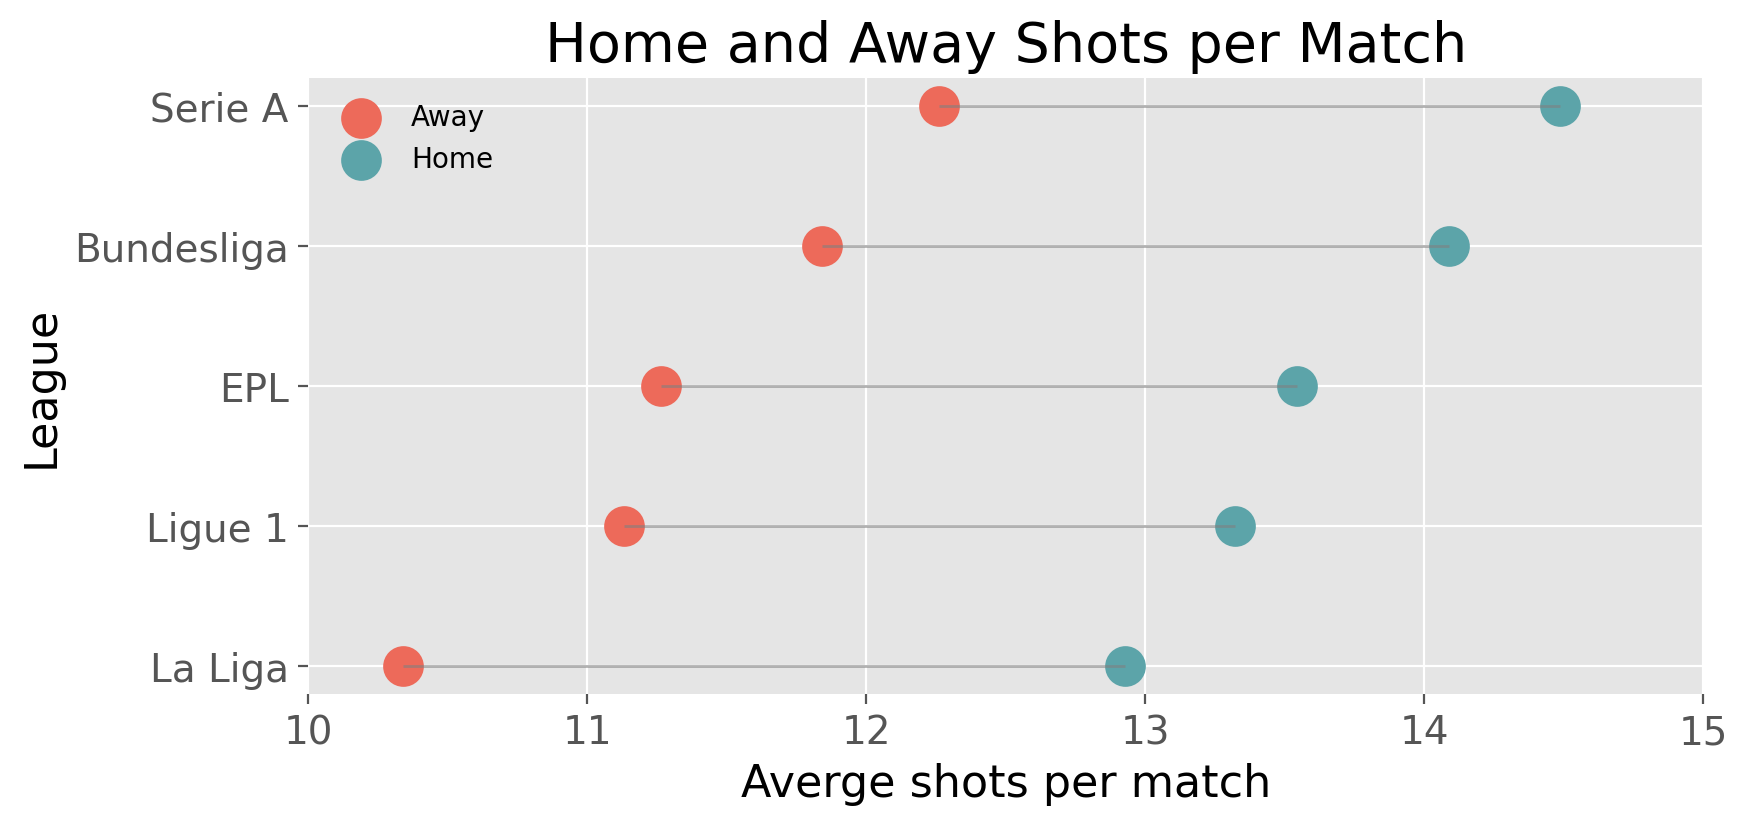

In [25]:
fig, ax = plt.subplots(figsize = (9, 4))
ax.hlines(y=my_range, xmin=ordered_df['away_shots_per_match'], xmax=ordered_df['home_shots_per_match'], color='grey', alpha=0.6, linewidth=1)
ax.scatter(ordered_df['away_shots_per_match'], my_range, color='#ED6A5A', label='Away', alpha=1, s=160, lw = 2)
ax.scatter(ordered_df['home_shots_per_match'], my_range, color='#5CA4A9' , label='Home', alpha=1 , s=160, lw = 2)
# no border around legend
ax.legend(frameon=False)
# larger legend

plt.yticks(my_range, ordered_df['league'])
plt.title("Home and Away Shots per Match", size=20, color='black')
plt.xlabel('Averge shots per match', color='black', size=16)
plt.ylabel('League', color='black', size=16)

# larger x ticks
plt.xticks(size=14)
# larger y ticks
plt.yticks(size=14)
# start x axis at 10
plt.xlim(10, 15)

ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# save with transparent background and make it tight
plt.savefig('home_away_shots.png', transparent=True, bbox_inches='tight')

plt.show()